In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim import AdamW, LBFGS
from torch import GradScaler
from scipy.linalg import expm
from scipy.optimize import minimize

In [2]:
# One-qubit operators
sigma_x = torch.tensor([[0., 1.], [1., 0.]], dtype=torch.complex64)
sigma_y = torch.tensor([[0., -1j], [1j, 0.]], dtype=torch.complex64)
sigma_z = torch.tensor([[1., 0.], [0., -1.]], dtype=torch.complex64)
identity = torch.eye(2, dtype=torch.complex64)
# Two-qubit operators
# Qubit 1 controls
sx1 = torch.kron(sigma_x, identity)  # σₓ ⊗ I
sz1 = torch.kron(sigma_z, identity)  # σ_z ⊗ I
# Qubit 2 controls
sx2 = torch.kron(identity, sigma_x)  # I ⊗ σₓ
sz2 = torch.kron(identity, sigma_z)  # I ⊗ σ_z
# Coupling
szx = torch.kron(sigma_z, sigma_x)  # σ_z ⊗ σ_z

In [3]:
H_target = (1/np.sqrt(2)) * torch.tensor([[1., 1.], [1., -1.]], dtype=torch.complex64)
T_target = torch.tensor([[1., 0.], [0., np.exp(1j * np.pi / 4)]], dtype=torch.complex64)
CNOT_target = torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
], dtype=torch.complex64)

In [4]:
# System parameters
T_total = 1.0    # total time
N = 9           # number of time steps
dt = T_total / N # delta time
time_grid = torch.linspace(0, T_total, N)
K = 5
freqs = torch.linspace(1.0, 5.0, K)
omega0 = 2 * np.pi / T_total

In [5]:
# GRAPE
def propagate_grape(params, target):
  if target.shape[0] == 2:
    u_x = params['ux']
    u_z = params['uz']
    U = torch.eye(2, dtype=torch.complex64)
    for n in range(N):
      H = u_x[n] * sigma_x + u_z[n] * sigma_z
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  else:
    u1x = params['u1x']
    u1z = params['u1z']
    u2x = params['u2x']
    u2z = params['u2z']
    jzx = params['jzx']
    U = torch.eye(4, dtype=torch.complex64)
    for n in range(N):
      H = jzx[n] * szx + u1x[n] * sx1 + u1z[n] * sz1 + u2x[n] * sx2 + u2z[n] * sz2
      U_step = torch.matrix_exp(-1j * H * dt)
      U = U_step @ U
  return U

def process_fidelity_grape(U, U_target):
    dim = U_target.shape[0]
    fidelity = torch.clamp((torch.abs(torch.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = torch.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def loss_fn_grape(U, U_target):
    # Compute the global phase factor from the trace overlap
    trace_val = torch.trace(U_target.conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = torch.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = torch.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = U_target - U_aligned
    loss = torch.norm(diff, p='fro')**2
    return loss

def train_grape(iters, optimizer, params, target):
  scaler = GradScaler('cpu')
  loss_list, fid_list, inf_list = [], [], []
  for it in range(iters):
    optimizer.zero_grad(set_to_none=True)
    U = propagate_grape(params, target)
    loss = loss_fn_grape(U, target)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    fid, inf = process_fidelity_grape(U, target)
    loss_list.append(loss.item())
    fid_list.append(fid)
    inf_list.append(inf)
    if it % 100 == 0 or it == num_iters-1:
        print(f"Iteration {it}: Loss = {loss.item()}")
        print(f"Fidelity = {fid}, Infidelity = {inf}")
  return loss_list, fid_list, inf_list

In [6]:
# CRAB
def process_fidelity_crab(U, U_target):
    dim = U_target.shape[0]
    fidelity = np.clip((np.abs(np.trace(U_target.conj().T @ U) / dim))**2, 0, 1)
    infidelity = np.log10(1 - fidelity)
    return fidelity.item(), infidelity.item()

def drive_control(t, x):
    # x[0:K]: alpha coefficients, x[K:2K]: beta coefficients.
    alphas = x[:K]
    betas = x[K:2*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += alphas[k-1] * np.cos(k * omega0 * t) + betas[k-1] * np.sin(k * omega0 * t)
    return pulse

def detuning_control(t, x):
    # x[2K:3K]: gamma coefficients, x[3K:4K]: delta coefficients.
    gammas = x[2*K:3*K]
    deltas = x[3*K:4*K]
    pulse = 0.0
    for k in range(1, K+1):
        pulse += gammas[k-1] * np.cos(k * omega0 * t) + deltas[k-1] * np.sin(k * omega0 * t)
    return pulse

# Total control pulse applied in the Hamiltonian.
# H(t) = εₓ(t) σ_x + ε_z(t) σ_z.
def hamiltonian(t, x):
    eps_x = drive_control(t, x)
    eps_z = detuning_control(t, x)
    return eps_x * sigma_x + eps_z * sigma_z

def propagate_crab(x):
  U = np.eye(2).copy()
  for t in time_grid:
    H = hamiltonian(t, x)
    U_step = expm(-1j * H * dt)
    U = U_step @ U
  return U

In [7]:
ux_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_adam, 'uz': uz_grape_h_adam}
optimizer = AdamW([ux_grape_h_adam, uz_grape_h_adam], lr=0.001, weight_decay=0.001)

In [8]:
num_iters = 3000
loss_list_grape_h_adam, fid_list_grape_h_adam, inf_list_grape_h_adam = train_grape(num_iters, optimizer, params, H_target)

Iteration 0: Loss = 3.462500810623169
Fidelity = 0.018056513741612434, Infidelity = -0.007913505658507347
Iteration 100: Loss = 2.926015853881836
Fidelity = 0.07209008932113647, Infidelity = -0.032494187355041504
Iteration 200: Loss = 2.420804262161255
Fidelity = 0.1558661013841629, Infidelity = -0.07358865439891815
Iteration 300: Loss = 1.9602739810943604
Fidelity = 0.2600300908088684, Infidelity = -0.13078594207763672
Iteration 400: Loss = 1.5535593032836914
Fidelity = 0.37406685948371887, Infidelity = -0.20347203314304352
Iteration 500: Loss = 1.2053297758102417
Fidelity = 0.48813605308532715, Infidelity = -0.29084545373916626
Iteration 600: Loss = 0.9160481095314026
Fidelity = 0.594421923160553, Infidelity = -0.39192551374435425
Iteration 700: Loss = 0.6826813220977783
Fidelity = 0.6877869367599487, Infidelity = -0.5055489540100098
Iteration 800: Loss = 0.4996712803840637
Fidelity = 0.7657681107521057, Infidelity = -0.6303539872169495
Iteration 900: Loss = 0.3599646985530853
Fideli

In [9]:
ux_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_h_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_h_lbfgs, 'uz': uz_grape_h_lbfgs}

loss_list_grape_h_lbfgs, fid_list_grape_h_lbfgs, inf_list_grape_h_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, H_target)
  loss = loss_fn_grape(U, H_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, H_target)
  loss_list_grape_h_lbfgs.append(loss.item())
  fid_list_grape_h_lbfgs.append(fid)
  inf_list_grape_h_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_h_lbfgs , uz_grape_h_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_h_lbfgs[-1]}, Infidelity: {inf_list_grape_h_lbfgs[-1]}")

Iteration 0, Loss: 3.66516375541687
Fidelity: 0.06894902884960175, Infidelity: -0.031026549637317657
Iteration 10, Loss: 1.2040587663650513
Fidelity: 0.520777702331543, Infidelity: -0.31946298480033875
Iteration 20, Loss: 0.4922640025615692
Fidelity: 0.7826486229896545, Infidelity: -0.6628376245498657
Iteration 30, Loss: 0.2122984528541565
Fidelity: 0.9031622409820557, Infidelity: -1.0139552354812622
Iteration 40, Loss: 0.10218450427055359
Fidelity: 0.9529796838760376, Infidelity: -1.327714443206787
Iteration 50, Loss: 0.0496547557413578
Fidelity: 0.9767045378684998, Infidelity: -1.6327286958694458
Iteration 60, Loss: 0.02127578854560852
Fidelity: 0.9902252554893494, Infidelity: -2.009894609451294
Iteration 70, Loss: 0.008808065205812454
Fidelity: 0.995989203453064, Infidelity: -2.3967692852020264
Iteration 80, Loss: 0.0034431624226272106
Fidelity: 0.9983989596366882, Infidelity: -2.795597791671753
Iteration 90, Loss: 0.0017211431404575706
Fidelity: 0.999183714389801, Infidelity: -3.08

In [10]:
loss_list_crab_h, fid_list_crab_h, inf_list_crab_h = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(H_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = H_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_h.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, H_target.numpy())
    fid_list_crab_h.append(fid)
    inf_list_crab_h.append(inf)
    return loss

In [11]:
x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_777160/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 780
         Function evaluations: 1151


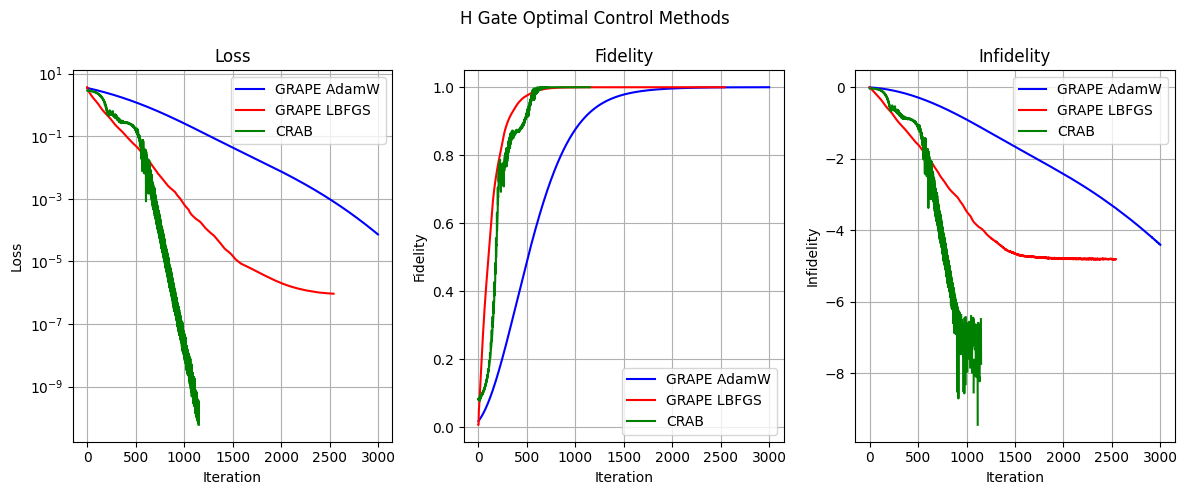

In [12]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle("H Gate Optimal Control Methods")
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_h, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_h, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_h_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_h_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_h, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Methods.png"
)
plt.tight_layout()
plt.show()

In [46]:
pd.DataFrame({'loss_grape_h_adam': loss_list_grape_h_adam, 'fid_grape_h_adam': fid_list_grape_h_adam, 'inf_grape_h_adam': inf_list_grape_h_adam}).to_csv('grape_h_adam.csv')
pd.DataFrame({'loss_grape_h_lbfgs': loss_list_grape_h_lbfgs, 'fid_grape_h_lbfgs': fid_list_grape_h_lbfgs, 'inf_grape_h_lbfgs': inf_list_grape_h_lbfgs}).to_csv('grape_h_lbfgs.csv')
pd.DataFrame({'loss_crab_h': loss_list_crab_h, 'fid_crab_h': fid_list_crab_h, 'inf_crab_h': inf_list_crab_h}).to_csv('crab_h.csv')

In [14]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_h_adam = ux_grape_h_adam.detach().cpu().numpy()
uz_grape_h_adam = uz_grape_h_adam.detach().cpu().numpy()
ux_grape_h_lbfgs = ux_grape_h_lbfgs.detach().cpu().numpy()
uz_grape_h_lbfgs = uz_grape_h_lbfgs.detach().cpu().numpy()

x_opt = res.x
ux_grape_h_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_h_crab = [detuning_control(t, x_opt) for t in time_grid]

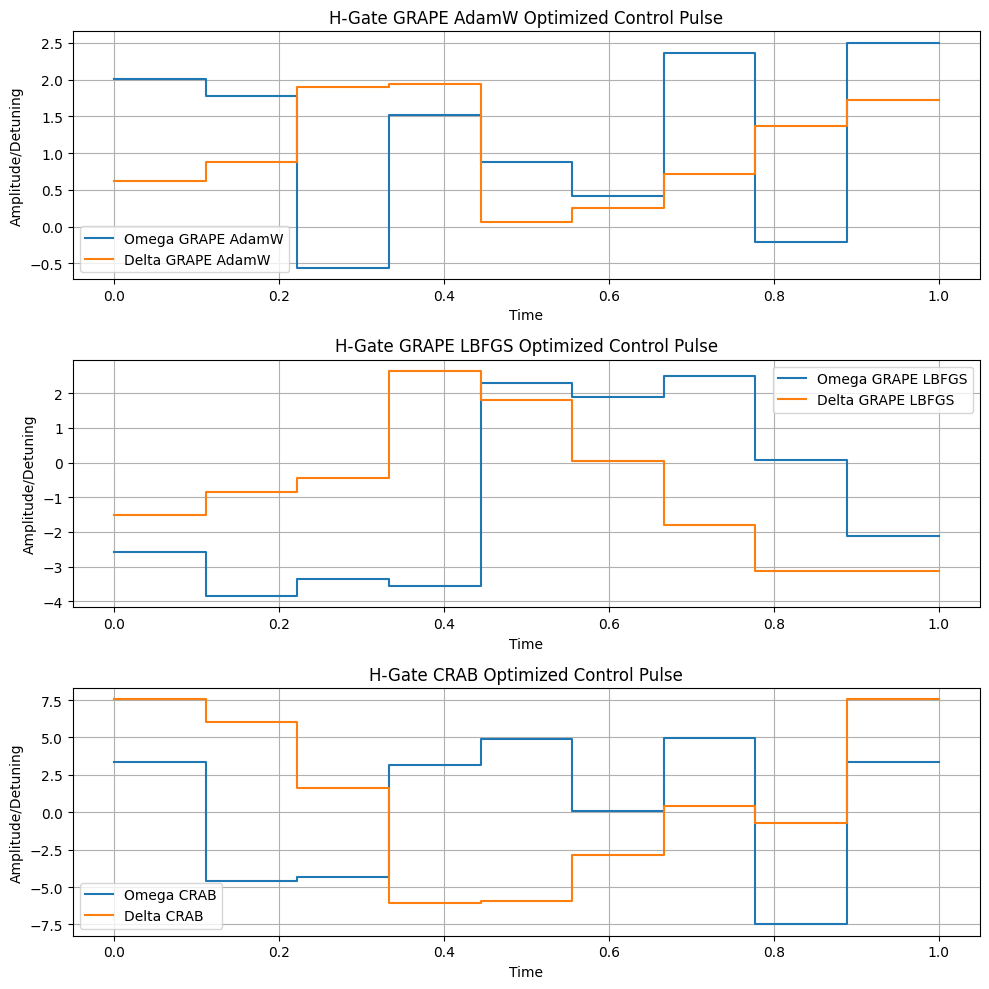

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.step(time_edges, np.append(ux_grape_h_adam, ux_grape_h_adam[-1]), where='post', label='Omega GRAPE AdamW')
plt.step(time_edges, np.append(uz_grape_h_adam, uz_grape_h_adam[-1]), where='post', label='Delta GRAPE AdamW')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.step(time_edges, np.append(ux_grape_h_lbfgs, ux_grape_h_lbfgs[-1]), where='post', label='Omega GRAPE LBFGS')
plt.step(time_edges, np.append(uz_grape_h_lbfgs, uz_grape_h_lbfgs[-1]), where='post', label='Delta GRAPE LBFGS')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(time_edges, np.append(ux_grape_h_crab, ux_grape_h_crab[-1]), where='post', label='Omega CRAB')
plt.step(time_edges, np.append(uz_grape_h_crab, uz_grape_h_crab[-1]), where='post', label='Delta CRAB')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("H-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "/home/pdconte/Desktop/DUTh_Thesis/Plots/H_Gate_Optimal_Control_Pulses.png"
)
plt.show()

In [16]:
# T-Gate
ux_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_adam, 'uz': uz_grape_t_adam}
optimizer = AdamW([ux_grape_t_adam, uz_grape_t_adam], lr=0.001, weight_decay=0.001)

In [17]:
num_iters = 1200
loss_list_grape_t_adam, fid_list_grape_t_adam, inf_list_grape_t_adam = train_grape(num_iters, optimizer, params, T_target)

Iteration 0: Loss = 2.0911459922790527
Fidelity = 0.22773264348506927, Infidelity = -0.11223232746124268
Iteration 100: Loss = 1.6696144342422485
Fidelity = 0.3394183814525604, Infidelity = -0.18007352948188782
Iteration 200: Loss = 1.3123170137405396
Fidelity = 0.45147705078125, Infidelity = -0.2608051896095276
Iteration 300: Loss = 1.0184496641159058
Fidelity = 0.5556022524833679, Infidelity = -0.35222816467285156
Iteration 400: Loss = 0.7817838788032532
Fidelity = 0.6473070383071899, Infidelity = -0.45260322093963623
Iteration 500: Loss = 0.5936667919158936
Fidelity = 0.7251937985420227, Infidelity = -0.5609734654426575
Iteration 600: Loss = 0.44531846046447754
Fidelity = 0.789734959602356, Infidelity = -0.6772329211235046
Iteration 700: Loss = 0.3292090594768524
Fidelity = 0.842168927192688, Infidelity = -0.8018074631690979
Iteration 800: Loss = 0.23934553563594818
Fidelity = 0.8839074969291687, Infidelity = -0.935195803642273
Iteration 900: Loss = 0.170915424823761
Fidelity = 0.91

In [18]:
ux_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
uz_grape_t_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))
params = {'ux': ux_grape_t_lbfgs, 'uz': uz_grape_t_lbfgs}

loss_list_grape_t_lbfgs, fid_list_grape_t_lbfgs, inf_list_grape_t_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, T_target)
  loss = loss_fn_grape(U, T_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, T_target)
  loss_list_grape_t_lbfgs.append(loss.item())
  fid_list_grape_t_lbfgs.append(fid)
  inf_list_grape_t_lbfgs.append(inf)
  return loss

optimizer = LBFGS([ux_grape_t_lbfgs , uz_grape_t_lbfgs], lr=0.001, max_iter=10)

num_iterations = 120
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_grape_t_lbfgs[-1]}, Infidelity: {inf_list_grape_t_lbfgs[-1]}")

Iteration 0, Loss: 0.8450303077697754
Fidelity: 0.6287824511528015, Infidelity: -0.43037149310112
Iteration 10, Loss: 0.43577447533607483
Fidelity: 0.801664412021637, Infidelity: -0.7025993466377258
Iteration 20, Loss: 0.2643829882144928
Fidelity: 0.8784098029136658, Infidelity: -0.9151014089584351
Iteration 30, Loss: 0.13629648089408875
Fidelity: 0.9372844696044922, Infidelity: -1.2026249170303345
Iteration 40, Loss: 0.06316143274307251
Fidelity: 0.9707061648368835, Infidelity: -1.5332237482070923
Iteration 50, Loss: 0.030296869575977325
Fidelity: 0.9858700633049011, Infidelity: -1.8498598337173462
Iteration 60, Loss: 0.014681776985526085
Fidelity: 0.9930768013000488, Infidelity: -2.1596932411193848
Iteration 70, Loss: 0.007160193752497435
Fidelity: 0.9966371059417725, Infidelity: -2.4732868671417236
Iteration 80, Loss: 0.0036688297986984253
Fidelity: 0.9982843399047852, Infidelity: -2.765568733215332
Iteration 90, Loss: 0.0018329768208786845
Fidelity: 0.9991157650947571, Infidelity: 

In [19]:
loss_list_crab_t, fid_list_crab_t, inf_list_crab_t = [], [], []

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(T_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = T_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_t.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, T_target.numpy())
    fid_list_crab_t.append(fid)
    inf_list_crab_t.append(inf)
    return loss

x0 = np.random.randn(4 * K)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 5000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_777160/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 571
         Function evaluations: 868


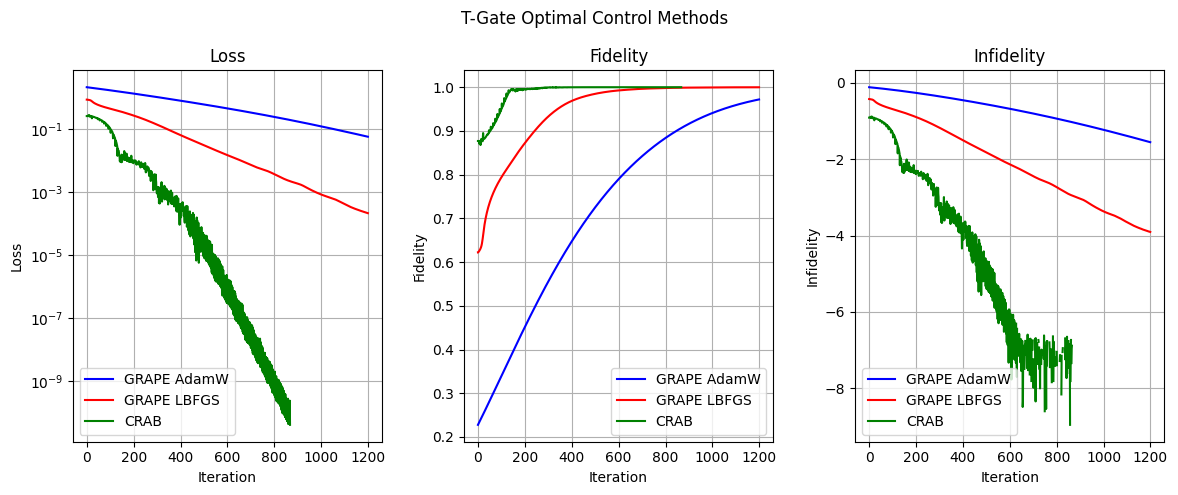

In [20]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('T-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_t, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_t, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_t_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_grape_t_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_t, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Methods.png')
plt.show()

In [21]:
pd.DataFrame({'loss_grape_t_adam': loss_list_grape_t_adam, 'fid_grape_t_adam': fid_list_grape_t_adam, 'inf_grape_t_adam': inf_list_grape_t_adam}).to_csv('grape_t_adam.csv')
pd.DataFrame({'loss_grape_t_lbfgs': loss_list_grape_t_lbfgs, 'fid_grape_t_lbfgs': fid_list_grape_t_lbfgs, 'inf_grape_t_lbfgs': inf_list_grape_t_lbfgs}).to_csv('grape_t_lbfgs.csv')
pd.DataFrame({'loss_crab_t': loss_list_crab_t, 'fid_crab_t': fid_list_crab_t, 'inf_crab_t': inf_list_crab_t}).to_csv('crab_t.csv')

In [22]:
# Plot the optimized control pulses
time_edges = np.linspace(0, T_total, N+1)
ux_grape_t_adam = ux_grape_t_adam.detach().cpu().numpy()
uz_grape_t_adam = uz_grape_t_adam.detach().cpu().numpy()
ux_grape_t_lbfgs = ux_grape_t_lbfgs.detach().cpu().numpy()
uz_grape_t_lbfgs = uz_grape_t_lbfgs.detach().cpu().numpy()
x_opt = res.x
ux_grape_t_crab = [drive_control(t, x_opt) for t in time_grid]
uz_grape_t_crab = [detuning_control(t, x_opt) for t in time_grid]

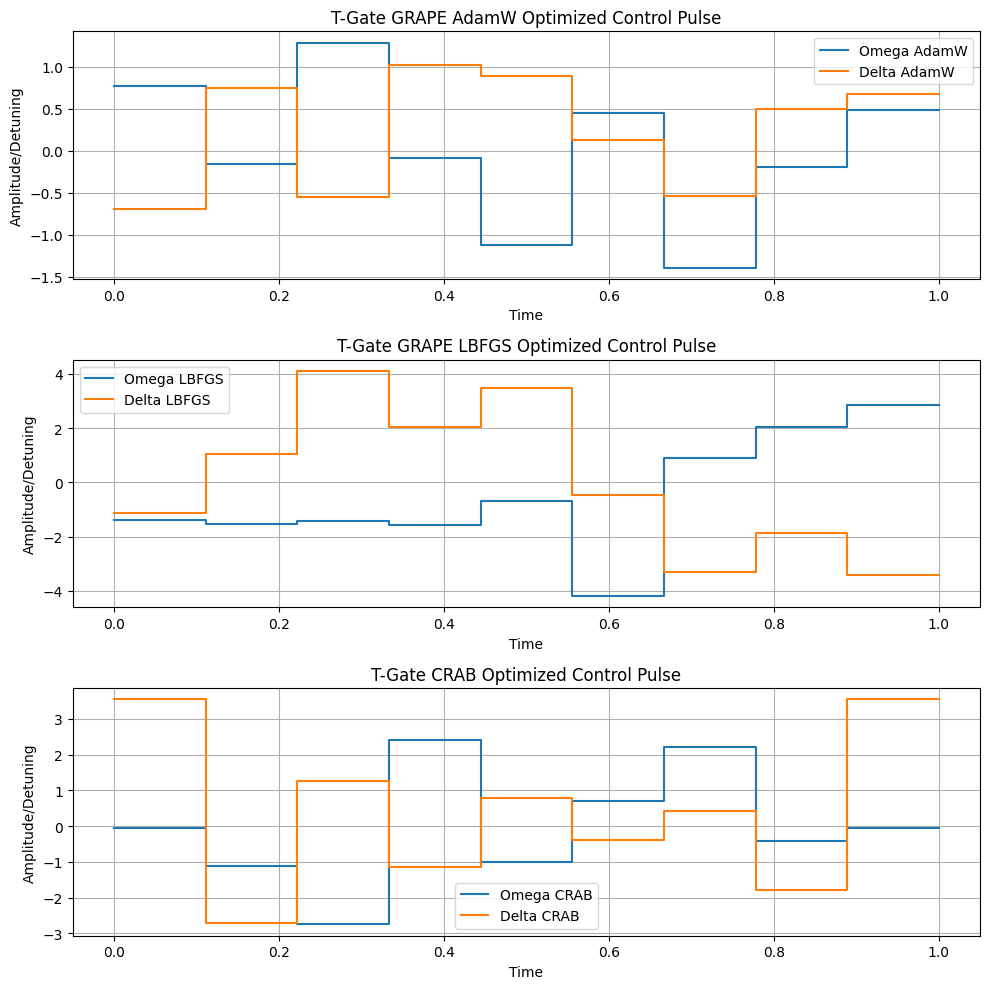

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.step(time_edges, np.append(ux_grape_t_adam, ux_grape_t_adam[-1]), where='post', label='Omega AdamW')
plt.step(time_edges, np.append(uz_grape_t_adam, uz_grape_t_adam[-1]), where='post', label='Delta AdamW')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.step(time_edges, np.append(ux_grape_t_lbfgs, ux_grape_t_lbfgs[-1]), where='post', label='Omega LBFGS')
plt.step(time_edges, np.append(uz_grape_t_lbfgs, uz_grape_t_lbfgs[-1]), where='post', label='Delta LBFGS')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)
plt.step(time_edges, np.append(ux_grape_t_crab, ux_grape_t_crab[-1]), where='post', label='Omega CRAB')
plt.step(time_edges, np.append(uz_grape_t_crab, uz_grape_t_crab[-1]), where='post', label='Delta CRAB')
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("T-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/T_Gate_Optimal_Control_Pulses.png')
plt.show()

In [35]:
N = 5  # number of time steps
dt = T_total / N  # delta time
time_grid = torch.linspace(0, T_total, N)

In [36]:
u1x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_adam = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_adam, 'u1z': u1z_grape_cnot_adam, 'u2x': u2x_grape_cnot_adam, 'u2z': u2z_grape_cnot_adam, 'jzx': jzx_grape_cnot_adam}
optimizer = AdamW([u1x_grape_cnot_adam, u1z_grape_cnot_adam, u2x_grape_cnot_adam, u2z_grape_cnot_adam, jzx_grape_cnot_adam], lr=0.001, weight_decay=0.001)

In [37]:
num_iters = 3000
loss_list_grape_cnot_adam, fid_list_grape_cnot_adam, inf_list_grape_cnot_adam = train_grape(num_iters, optimizer, params, CNOT_target)

Iteration 0: Loss = 5.732634544372559
Fidelity = 0.08032689243555069, Infidelity = -0.03636652231216431
Iteration 100: Loss = 5.048892974853516
Fidelity = 0.13607832789421082, Infidelity = -0.06352564692497253
Iteration 200: Loss = 4.495509624481201
Fidelity = 0.19189725816249847, Infidelity = -0.0925334244966507
Iteration 300: Loss = 3.8388216495513916
Fidelity = 0.27055269479751587, Infidelity = -0.13700607419013977
Iteration 400: Loss = 2.891494035720825
Fidelity = 0.40776297450065613, Infidelity = -0.22750446200370789
Iteration 500: Loss = 1.9312927722930908
Fidelity = 0.5754556655883789, Infidelity = -0.37207695841789246
Iteration 600: Loss = 1.201711654663086
Fidelity = 0.7221329808235168, Infidelity = -0.5561630129814148
Iteration 700: Loss = 0.7206016778945923
Fidelity = 0.827957808971405, Infidelity = -0.764365017414093
Iteration 800: Loss = 0.4232980012893677
Fidelity = 0.8969721794128418, Infidelity = -0.9870454668998718
Iteration 900: Loss = 0.24452728033065796
Fidelity = 0

In [38]:
u1x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σₓ control
u1z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 1: σ_z control
u2x_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σₓ control
u2z_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Qubit 2: σ_z control
jzx_grape_cnot_lbfgs = torch.nn.Parameter(torch.randn(N, dtype=torch.float64))  # Coupling Strength
params = {'u1x': u1x_grape_cnot_lbfgs, 'u1z': u1z_grape_cnot_lbfgs, 'u2x': u2x_grape_cnot_lbfgs, 'u2z': u2z_grape_cnot_lbfgs, 'jzx': jzx_grape_cnot_lbfgs}

loss_list_cnot_grape_lbfgs, fid_list_cnot_grape_lbfgs, inf_list_cnot_grape_lbfgs = [], [], []

def closure():
  optimizer.zero_grad(set_to_none=True)
  U = propagate_grape(params, CNOT_target)
  loss = loss_fn_grape(U, CNOT_target)
  loss.backward()
  fid, inf = process_fidelity_grape(U, CNOT_target)
  loss_list_cnot_grape_lbfgs.append(loss.item())
  fid_list_cnot_grape_lbfgs.append(fid)
  inf_list_cnot_grape_lbfgs.append(inf)
  return loss

optimizer = LBFGS([u1x_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs, jzx_grape_cnot_lbfgs], lr=0.001, max_iter=10)

num_iterations = 300
for i in range(num_iterations):
  loss = optimizer.step(closure)
  if i % 10 == 0 or i == num_iterations - 1:
    print(f"Iteration {i}, Loss: {loss.item()}")
    print(f"Fidelity: {fid_list_cnot_grape_lbfgs[-1]}, Infidelity: {inf_list_cnot_grape_lbfgs[-1]}")

Iteration 0, Loss: 4.009944438934326
Fidelity: 0.25412067770957947, Infidelity: -0.1273314505815506
Iteration 10, Loss: 2.7604482173919678
Fidelity: 0.44861117005348206, Infidelity: -0.258542001247406
Iteration 20, Loss: 1.6925674676895142
Fidelity: 0.632916271686554, Infidelity: -0.4352348744869232
Iteration 30, Loss: 1.0133506059646606
Fidelity: 0.7738619446754456, Infidelity: -0.6456263661384583
Iteration 40, Loss: 0.5720633864402771
Fidelity: 0.8684886693954468, Infidelity: -0.8810368180274963
Iteration 50, Loss: 0.31347304582595825
Fidelity: 0.9271672964096069, Infidelity: -1.1376736164093018
Iteration 60, Loss: 0.18370947241783142
Fidelity: 0.9568251371383667, Infidelity: -1.3647689819335938
Iteration 70, Loss: 0.102295882999897
Fidelity: 0.9756519198417664, Infidelity: -1.6135352849960327
Iteration 80, Loss: 0.06344965845346451
Fidelity: 0.9849364161491394, Infidelity: -1.8220716714859009
Iteration 90, Loss: 0.04059979319572449
Fidelity: 0.9902183413505554, Infidelity: -2.009587

In [39]:
num_channels = 5   # drive, detuning, coupling.
N_params = num_channels * (2 * K)

loss_list_crab_cnot, fid_list_crab_cnot, inf_list_crab_cnot = [], [], []

# Function to construct a control pulse at time t given Fourier coefficients.
def control_pulse(t, coeffs):
    # coeffs is a vector of length 2*K.
    val = 0.0
    for k in range(1, K+1):
        alpha = coeffs[k-1]
        beta  = coeffs[K + k - 1]
        val += alpha * np.cos(k * omega0 * t) + beta * np.sin(k * omega0 * t)
    return val

# Full Hamiltonian at time t, given control parameters x.
def H_total(t, x):
    # Channel 1: drive1 (first 2*K coefficients)
    # Channel 2: detuning1 (next 2*K)
    # Channel 3: drive2 (next 2*K)
    # Channel 4: detuning2 (next 2*K)
    # Channel 5: coupling (last 2*K)
    coeff_drive1    = x[0:2*K]
    coeff_detuning1 = x[2*K:4*K]
    coeff_drive2    = x[4*K:6*K]
    coeff_detuning2 = x[6*K:8*K]
    coeff_coupling  = x[8*K:10*K]

    eps_drive1    = control_pulse(t, coeff_drive1)
    eps_detuning1 = control_pulse(t, coeff_detuning1)
    eps_drive2    = control_pulse(t, coeff_drive2)
    eps_detuning2 = control_pulse(t, coeff_detuning2)
    eps_coupling  = control_pulse(t, coeff_coupling)

    H = (eps_drive1 * sx1 +
         eps_detuning1 * sz1 +
         eps_drive2 * sx2+
         eps_detuning2 * sz2 +
         eps_coupling * szx)
    return H

def propagate_crab(x):
    U = np.eye(4, dtype=complex)
    for t in time_grid:
        H = H_total(t, x)
        U_step = expm(-1j * H * dt)
        U = U_step @ U
    return U

def loss_fn_crab(x):
    U = propagate_crab(x)
    # Compute the global phase factor from the trace overlap
    trace_val = np.trace(CNOT_target.numpy().conj().T @ U)
    # Add a small constant to avoid division by zero
    phase = np.angle(trace_val + 1e-8)
    # Phase factor to cancel the global phase
    phase_factor = np.exp(-1j * phase)
    U_aligned = U * phase_factor
    diff = CNOT_target.numpy() - U_aligned
    loss = np.linalg.norm(diff, ord='fro')**2
    loss_list_crab_cnot.append(loss)
    fid, inf = process_fidelity_crab(U_aligned, CNOT_target.numpy())
    fid_list_crab_cnot.append(fid)
    inf_list_crab_cnot.append(inf)
    return loss

x0 = np.random.randn(N_params)
res = minimize(loss_fn_crab, x0, method='Nelder-Mead', options={'maxiter': 10000, 'disp': True})# Optimize using Nelder-Mead.

/tmp/ipykernel_777160/488501137.py:5: RuntimeWarning: divide by zero encountered in log10
  infidelity = np.log10(1 - fidelity)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 5000
         Function evaluations: 6033


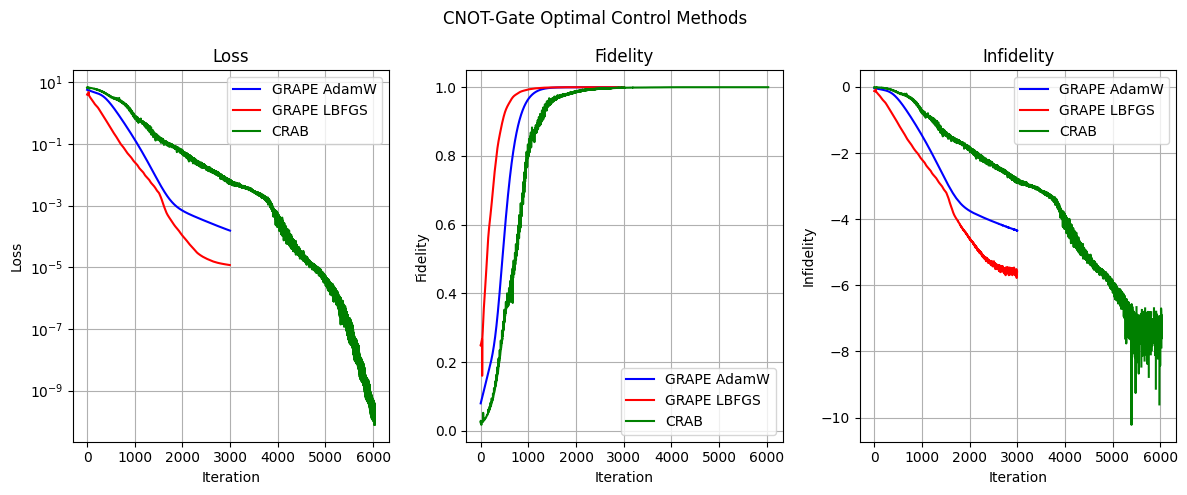

In [40]:
# plot loss, fid, inf
plt.figure(figsize=(12, 5))
plt.suptitle('CNOT-Gate Optimal Control Methods')
plt.subplot(1, 3, 1)
plt.plot(loss_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(loss_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(loss_list_crab_cnot, label='CRAB', color='green')
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.subplot(1, 3, 2)
plt.plot(fid_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(fid_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(fid_list_crab_cnot, label='CRAB', color='green')
plt.title('Fidelity')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.grid()
plt.subplot(1, 3, 3)
plt.plot(inf_list_grape_cnot_adam, label='GRAPE AdamW', color='blue')
plt.plot(inf_list_cnot_grape_lbfgs, label='GRAPE LBFGS', color='red')
plt.plot(inf_list_crab_cnot, label='CRAB', color='green')
plt.title('Infidelity')
plt.xlabel('Iteration')
plt.ylabel('Infidelity')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT-Gate Optimal Control Methods.png')
plt.show()

In [41]:
pd.DataFrame({'loss_grape_cnot_adam': loss_list_grape_cnot_adam, 'fid_grape_cnot_adam': fid_list_grape_cnot_adam, 'inf_grape_cnot_adam': inf_list_grape_cnot_adam}).to_csv('grape_cnot_adam.csv')
pd.DataFrame({'loss_grape_cnot_lbfgs': loss_list_cnot_grape_lbfgs, 'fid_grape_cnot_lbfgs': fid_list_cnot_grape_lbfgs, 'inf_grape_cnot_lbfgs': inf_list_cnot_grape_lbfgs}).to_csv('grape_cnot_lbfgs.csv')
pd.DataFrame({'loss_crab_cnot': loss_list_crab_cnot, 'fid_crab_cnot': fid_list_crab_cnot, 'inf_crab_cnot': inf_list_crab_cnot}).to_csv('crab_cnot.csv')

In [42]:
u1x_grape_cnot_adam = u1x_grape_cnot_adam.detach().cpu().numpy()
u1z_grape_cnot_adam = u1z_grape_cnot_adam.detach().cpu().numpy()
u2x_grape_cnot_adam = u2x_grape_cnot_adam.detach().cpu().numpy()
u2z_grape_cnot_adam = u2z_grape_cnot_adam.detach().cpu().numpy()
coup_str_adam = jzx_grape_cnot_adam.detach().cpu().numpy()

In [43]:
u1x_grape_cnot_lbfgs = u1x_grape_cnot_lbfgs.detach().cpu().numpy()
u1z_grape_cnot_lbfgs = u1z_grape_cnot_lbfgs.detach().cpu().numpy()
u2x_grape_cnot_lbfgs = u2x_grape_cnot_lbfgs.detach().cpu().numpy()
u2z_grape_cnot_lbfgs = u2z_grape_cnot_lbfgs.detach().cpu().numpy()
coup_str_lbfgs = jzx_grape_cnot_lbfgs.detach().cpu().numpy()

In [44]:
coeff_drive1_opt    = res.x[0:2*K]
coeff_detuning1_opt = res.x[2*K:4*K]
coeff_drive2_opt    = res.x[4*K:6*K]
coeff_detuning2_opt = res.x[6*K:8*K]
coeff_coupling_opt = res.x[8*K:10*K]
time_edges = np.linspace(0, T_total, N+1)
u1x_crab_cnot = np.array([control_pulse(t, coeff_drive1_opt) for t in time_grid])
u1z_crab_cnot = np.array([control_pulse(t, coeff_detuning1_opt) for t in time_grid])
u2x_crab_cnot = np.array([control_pulse(t, coeff_drive2_opt) for t in time_grid])
u2z_crab_cnot = np.array([control_pulse(t, coeff_detuning2_opt) for t in time_grid])
coup_str_crab = np.array([control_pulse(t, coeff_coupling_opt) for t in time_grid])

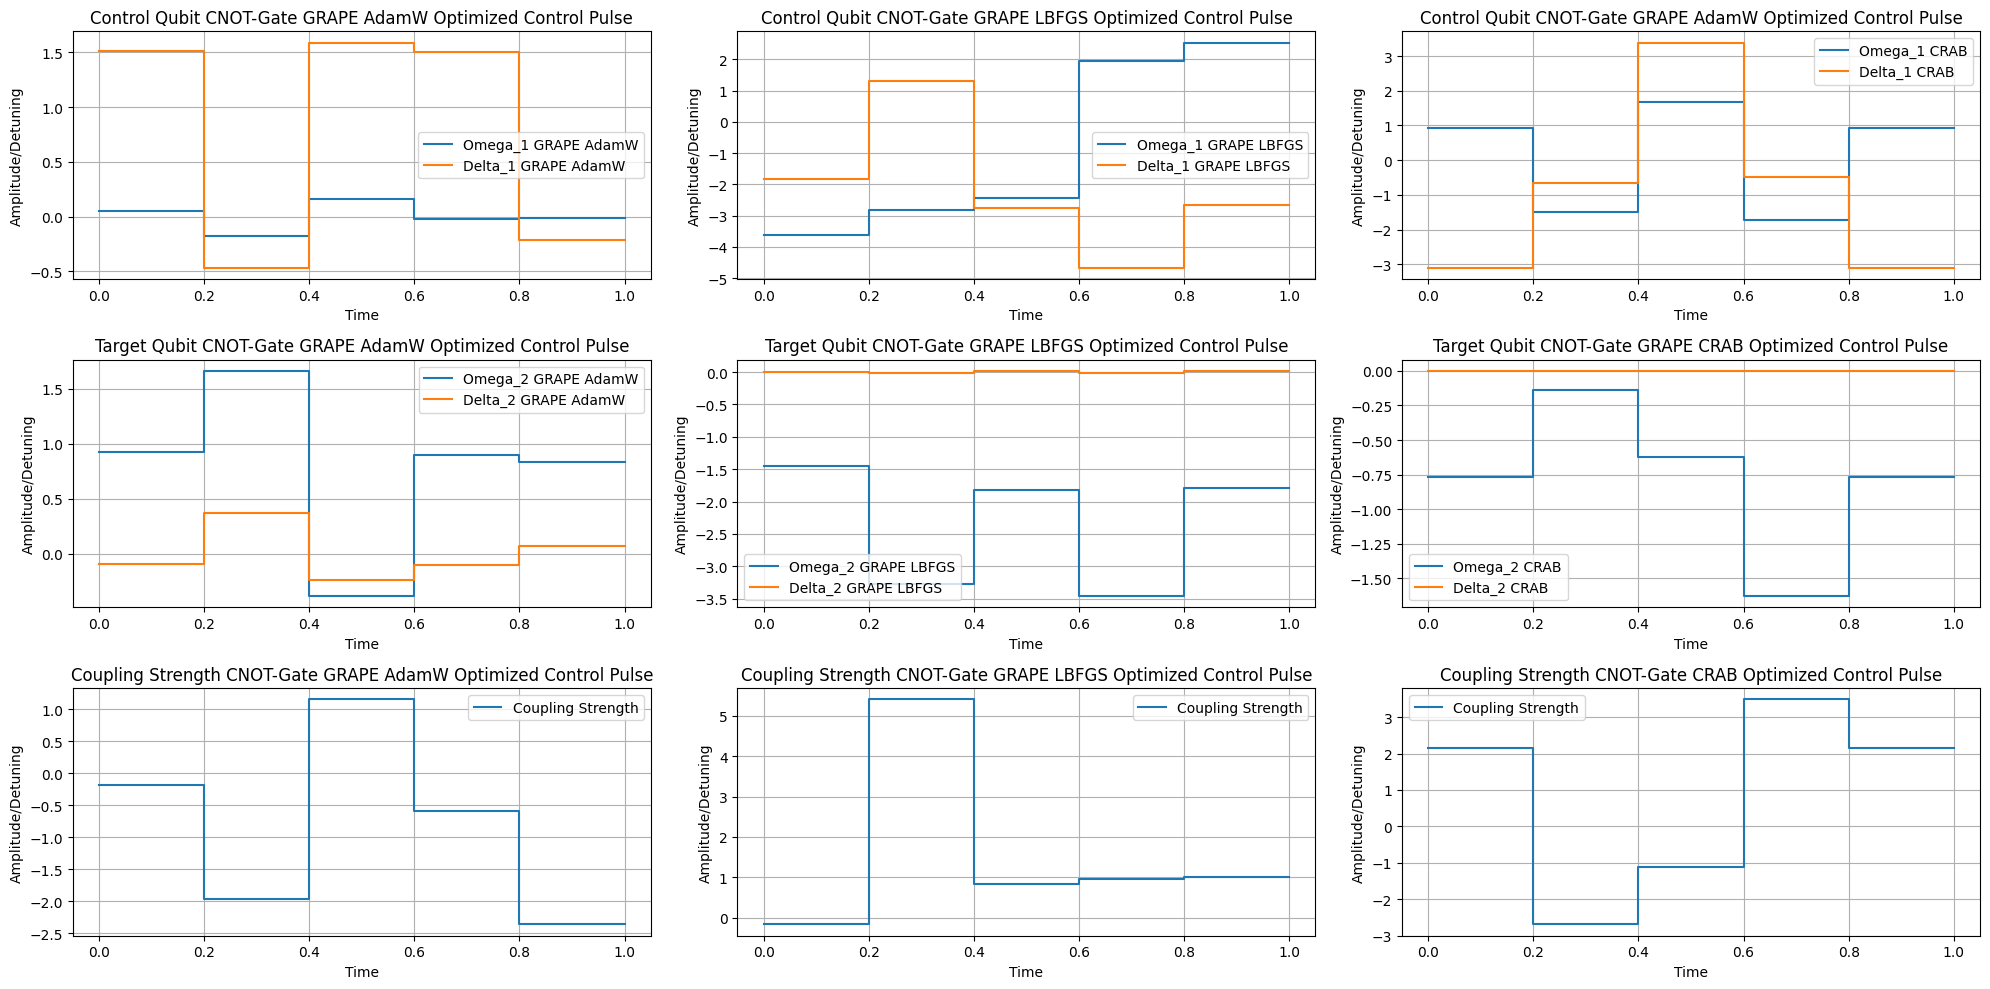

In [45]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 3, 1)
plt.step(time_edges, np.append(u1x_grape_cnot_adam, u1x_grape_cnot_adam[-1]), where='post', label="Omega_1 GRAPE AdamW")
plt.step(time_edges, np.append(u1z_grape_cnot_adam, u1z_grape_cnot_adam[-1]), where='post', label="Delta_1 GRAPE AdamW")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 2)
plt.step(time_edges, np.append(u1x_grape_cnot_lbfgs, u1x_grape_cnot_lbfgs[-1]), where='post', label="Omega_1 GRAPE LBFGS")
plt.step(time_edges, np.append(u1z_grape_cnot_lbfgs, u1z_grape_cnot_lbfgs[-1]), where='post', label="Delta_1 GRAPE LBFGS")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 3)
plt.step(time_edges, np.append(u1x_crab_cnot, u1x_crab_cnot[-1]), where='post', label="Omega_1 CRAB")
plt.step(time_edges, np.append(u1z_crab_cnot, u1z_crab_cnot[-1]), where='post', label="Delta_1 CRAB")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Control Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 4)
plt.step(time_edges, np.append(u2x_grape_cnot_adam, u2x_grape_cnot_adam[-1]), where='post', label="Omega_2 GRAPE AdamW")
plt.step(time_edges, np.append(u2z_grape_cnot_adam, u2z_grape_cnot_adam[-1]), where='post', label="Delta_2 GRAPE AdamW")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 5)
plt.step(time_edges, np.append(u2x_grape_cnot_lbfgs, u2x_grape_cnot_lbfgs[-1]), where='post', label="Omega_2 GRAPE LBFGS")
plt.step(time_edges, np.append(u2z_grape_cnot_lbfgs, u2z_grape_cnot_lbfgs[-1]), where='post', label="Delta_2 GRAPE LBFGS")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 6)
plt.step(time_edges, np.append(u2x_crab_cnot, u2x_crab_cnot[-1]), where='post', label="Omega_2 CRAB")
plt.step(time_edges, np.append(u2z_crab_cnot, u2z_crab_cnot[-1]), where='post', label="Delta_2 CRAB")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Target Qubit CNOT-Gate GRAPE CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 7)
plt.step(time_edges, np.append(coup_str_adam, coup_str_adam[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate GRAPE AdamW Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 8)
plt.step(time_edges, np.append(coup_str_lbfgs, coup_str_lbfgs[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate GRAPE LBFGS Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.subplot(3, 3, 9)
plt.step(time_edges, np.append(coup_str_crab, coup_str_crab[-1]), where='post', label="Coupling Strength")
plt.xlabel("Time")
plt.ylabel("Amplitude/Detuning")
plt.title("Coupling Strength CNOT-Gate CRAB Optimized Control Pulse")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/pdconte/Desktop/DUTh_Thesis/Plots/CNOT_Gate_Optimal_Control_Pulses.png')
plt.show()